In [18]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [19]:
import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                      exception_only=False, running_compiled_code=False):
       etype, value, tb = sys.exc_info()
       return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

In [20]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense, Flatten
from keras.layers import LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras.initializers import Constant
from keras.layers import *

import os
import pandas as pd
import numpy as np
from numpy import array
import re

In [21]:
fname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_final'}.xlsx")
cname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_case'}.xlsx")
lname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_law'}.xlsx")

dff = pd.read_excel(fname, index_col=0)
dfc = pd.read_excel(cname, index_col=0)
dfl = pd.read_excel(lname, index_col=0)

df = pd.concat([dff[['text', 'y_fine']], dfc[1:], dfl[1:]], axis=1).reindex(dff.index)
df = df.dropna(subset=['y_fine'])
df = df[df['y_fine'] >= 100000]
df = df[df['y_fine'] <= 3000000]

In [22]:
pd.options.display.float_format = '{:.2f}'.format
df.describe([.10, .20, .30, .40, .50, .60, .70, .80, .90])

,y_fine,가스방출,가스유출치사,가정폭력범죄의처,가정폭력범죄의처벌등에관한특례,가정폭력범죄의처벌등에관한특례법위반,가축분뇨의관리및이용에관한법률위반,간첩,간첩미수,간통,...,"('형사소송법', '제364조', ' 제2항')","('형사소송법', '제364조', ' 제4항')","('형사소송법', '제364조', ' 제6항')","('형사소송법', '제366조', '')","('형사소송법', '제369조', '')","('형사소송법', '제420조', '')","('형사소송법', '제422조', '')","('형사소송법', '제435조', ' 제1항')","('형사소송법', '제440조', '')","('화학물질관리법', '제59조', '')"
count,716.00,716.00,716.00,716.00,716.00,716.00,716.00,716.00,716.00,716.00,...,716.00,716.00,716.00,716.00,716.00,716.00,716.00,716.00,716.00,716.00
mean,1591470.99,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,...,0.01,0.01,0.04,0.00,0.02,0.00,0.00,0.00,0.00,0.00
std,984978.40,0.00,0.00,0.00,0.07,0.07,0.05,0.00,0.00,0.04,...,0.12,0.10,0.21,0.00,0.15,0.05,0.04,0.04,0.04,0.00
min,100000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10%,300000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
20%,500000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
30%,1000000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
40%,1000000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1500000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
60%,2000000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [23]:
X = df.drop('y_fine', axis=1)
y = df['y_fine']/100000

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [25]:
X1_train = X_train[dfc.columns[1:]]
X1_test = X_test[dfc.columns[1:]]

X2_train = X_train[dfl.columns[1:]]
X2_test = X_test[dfl.columns[1:]]


In [26]:
X3_train = list(X_train["text"])
X3_test = list(X_test["text"])

max_features = 30000
sequence_length = 128

tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(X3_train)

X3_train = tokenizer.texts_to_sequences(X3_train)
X3_test = tokenizer.texts_to_sequences(X3_test)

X3_train = pad_sequences(X3_train, sequence_length)
X3_test = pad_sequences(X3_test, sequence_length)

In [27]:
input_1 = Input(shape=(687,))
input_2 = Input(shape=(662,))

dense_layer_1_1 = Dense(10, activation='relu')(input_1)
dense_layer_1_2 = Dense(10, activation='relu')(dense_layer_1_1)
dense_layer_1_3 = Dense(10, activation='relu')(dense_layer_1_2)
dense_layer_1_4 = Dense(10, activation='relu')(dense_layer_1_3)
dropout_1_5 = Dropout(0.2)(dense_layer_1_4)


dense_layer_2_1 = Dense(10, activation='relu')(input_2)
dense_layer_2_2 = Dense(10, activation='relu')(dense_layer_2_1)
dense_layer_2_3 = Dense(10, activation='relu')(dense_layer_2_2)
dense_layer_2_4 = Dense(10, activation='relu')(dense_layer_2_3)
dropout_2_5 = Dropout(0.2)(dense_layer_2_4)

In [28]:
embeddings_index = {}
f = open(os.path.join(os.path.dirname(os.getcwd()), 'data_processing', 'ft_0814t.txt'),  encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

word_index = tokenizer.word_index

num_words = min(max_features, len(word_index)) + 1
print(num_words)
embedding_dim = 128
num_filters = 100

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)

11064


In [29]:
input_3 = Input(shape=(sequence_length,), dtype='int32')
embedding_layer_3 = Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=True)(input_3)

reshape_3 = Reshape((sequence_length, embedding_dim, 1))(embedding_layer_3)

conv_0_3 = Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_3)
conv_1_3 = Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_3)
conv_2_3 = Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_3)
conv_3_3 = Conv2D(num_filters, kernel_size=(6, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_3)

maxpool_0_3 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0_3)
maxpool_1_3 = MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1_3)
maxpool_2_3 = MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2_3)
maxpool_3_3 = MaxPool2D(pool_size=(sequence_length - 6 + 1, 1), strides=(1,1), padding='valid')(conv_3_3)

concatenated_tensor_3 = Concatenate(axis=1)([maxpool_0_3, maxpool_1_3, maxpool_2_3, maxpool_3_3])
flatten_3 = Flatten()(concatenated_tensor_3)
dropout_3 = Dropout(0.5)(flatten_3)

In [30]:
concat_layer = Concatenate()([dropout_1_5, dropout_2_5, dropout_3])

dense_layer_3 = Dense(10, activation='relu')(concat_layer)
dense_layer_4 = Dense(10, activation='relu')(dense_layer_3)
dense_layer_5 = Dense(10, activation='relu')(dense_layer_4)
dense_layer_6 = Dense(10, activation='relu')(dense_layer_5)

output = Dense(1, activation='linear')(dense_layer_3)

model = Model(inputs=[input_1, input_2, input_3], outputs=output)

In [31]:
model.compile(loss='mse', optimizer='Adamax', metrics=['mse', 'mae', 'mape', 'cosine'])
print(model.summary())
#Adamax

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 128, 128)     1416192     input_6[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 687)          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 662)          0                                            
____________________________________________________________________________________________

In [32]:
history = model.fit(x=[X1_train, X2_train, X3_train], y=y_train, batch_size=16, epochs=100, 
                   verbose=1, validation_split=0.1)# , callbacks=[early_stopping])

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 579 samples, validate on 65 samples
Epoch 1/100
579/579 [==============================] - 1s 1ms/step - loss: 234.0710 - mse: 192.9204 - mae: 11.3723 - mape: 120.5908 - cosine: 0.9447 - val_loss: 154.9159 - val_mse: 113.9550 - val_mae: 9.0512 - val_mape: 94.0852 - val_cosine: 1.0000
Epoch 2/100
579/579 [==============================] - 0s 594us/step - loss: 134.5191 - mse: 100.2371 - mae: 8.5653 - mape: 119.4955 - cosine: 1.0000 - val_loss: 134.5941 - val_mse: 105.2209 - val_mae: 8.8712 - val_mape: 95.9456 - val_cosine: 1.0000
Epoch 3/100
579/579 [==============================] - 0s 639us/step - loss: 121.1091 - mse: 93.2565 - mae: 8.4230 - mape: 127.7842 - cosine: 1.0000 - val_loss: 129.8649 - val_mse: 105.8120 - val_mae: 8.8247 - val_mape: 89.6156 - val_cosine: 1.0000
Epoch 4/100
579/579 [==============================] - 0s 607us/step - loss: 111.7366 - mse: 87.2324 - mae: 8.1164 - mape: 122.1107 - cosine: 1.0000 - val_loss: 126.0414 - val_mse: 103.5401 - val_mae: 8.7702

Epoch 34/100
579/579 [==============================] - 0s 590us/step - loss: 39.1337 - mse: 19.2870 - mae: 3.4881 - mape: 44.3414 - cosine: 0.9793 - val_loss: 123.2025 - val_mse: 103.2820 - val_mae: 8.5534 - val_mape: 107.2796 - val_cosine: 1.0000
Epoch 35/100
579/579 [==============================] - 0s 606us/step - loss: 39.3304 - mse: 19.4110 - mae: 3.5516 - mape: 44.6445 - cosine: 0.9827 - val_loss: 122.8469 - val_mse: 102.8733 - val_mae: 8.3806 - val_mape: 101.7841 - val_cosine: 1.0000
Epoch 36/100
579/579 [==============================] - 0s 580us/step - loss: 35.0916 - mse: 15.5055 - mae: 3.1617 - mape: 41.7801 - cosine: 0.9862 - val_loss: 119.8585 - val_mse: 100.7414 - val_mae: 8.3550 - val_mape: 91.7625 - val_cosine: 1.0000
Epoch 37/100
579/579 [==============================] - 0s 578us/step - loss: 34.6148 - mse: 15.6436 - mae: 3.1371 - mape: 38.1230 - cosine: 0.9793 - val_loss: 125.8668 - val_mse: 106.7529 - val_mae: 8.5351 - val_mape: 102.3650 - val_cosine: 1.0000
Epoch

Epoch 67/100
579/579 [==============================] - 0s 608us/step - loss: 25.3274 - mse: 10.2412 - mae: 2.4619 - mape: 29.7863 - cosine: 0.9827 - val_loss: 124.4826 - val_mse: 109.6154 - val_mae: 8.4922 - val_mape: 91.6119 - val_cosine: 1.0000
Epoch 68/100
579/579 [==============================] - 0s 603us/step - loss: 25.0419 - mse: 10.3116 - mae: 2.5277 - mape: 31.1127 - cosine: 0.9655 - val_loss: 125.3309 - val_mse: 111.0245 - val_mae: 8.5034 - val_mape: 87.2035 - val_cosine: 1.0000
Epoch 69/100
579/579 [==============================] - 0s 609us/step - loss: 25.4573 - mse: 10.8497 - mae: 2.5608 - mape: 30.5264 - cosine: 0.9793 - val_loss: 122.2315 - val_mse: 107.7698 - val_mae: 8.4280 - val_mape: 93.2049 - val_cosine: 1.0000
Epoch 70/100
579/579 [==============================] - 0s 610us/step - loss: 27.1540 - mse: 12.4787 - mae: 2.7257 - mape: 33.3540 - cosine: 0.9758 - val_loss: 123.3834 - val_mse: 108.5966 - val_mae: 8.4432 - val_mape: 93.2749 - val_cosine: 1.0000
Epoch 71

579/579 [==============================] - 0s 624us/step - loss: 21.1181 - mse: 8.7882 - mae: 2.3476 - mape: 29.6520 - cosine: 0.9896 - val_loss: 119.3146 - val_mse: 106.9121 - val_mae: 8.4944 - val_mape: 94.0394 - val_cosine: 1.0000


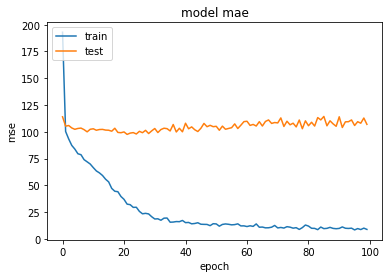

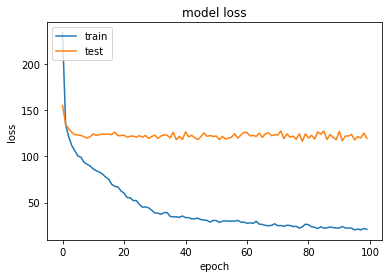

In [33]:
import matplotlib.pyplot as plt

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])

plt.title('model mae')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [34]:
score = model.evaluate(x=[X1_test, X2_test, X3_test], y=y_test, verbose=1)
print(score)
print("Test Score:", score[0])
print("Test MSE:", score[1])
#print("Test MAE: ", score[2])

72/72 [==============================] - 0s 249us/step
[93.24136564466689, 80.83889770507812, 7.2898101806640625, 114.13833618164062, 1.0]
Test Score: 93.24136564466689
Test MSE: 80.83889770507812


In [ ]:
# 0.1 100 / 70 80